Pretax Income ranging from 75000 to 345000
Avg approx error is 0.0038
Polynomial terms are [-4.94658938e-07  8.94934191e-01]


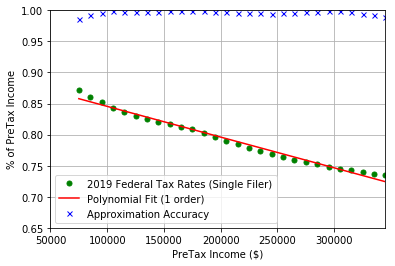

In [8]:
import scipy.optimize
import matplotlib.pyplot as plt
import numpy as np
import glfinancial as glf

pretax_income = np.arange(75 * 1000, 350 * 1000, 10 * 1000)
posttax_income = glf.posttax(pretax_income)
posttax_income_as_percent = posttax_income/pretax_income
polyfit_order = 1
approx_percent_polynom = np.poly1d(np.polyfit(pretax_income, posttax_income/pretax_income, polyfit_order))
approx_percent = approx_percent_polynom(pretax_income)
approximation_error = [abs(x-y) for x, y  in zip(approx_percent, posttax_income_as_percent)]
avg_approx_error = np.average(approximation_error)
approximation_accuracy = [1-x for x in approximation_error]

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))
print('Avg approx error is {:.2}'.format(avg_approx_error))
print('Polynomial terms are {}'.format(np.asarray(approx_percent_polynom)))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax_income_as_percent, 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, approx_percent, '-r', ms=5, label='Polynomial Fit ({} order)'.format(polyfit_order))
plt.plot(pretax_income, approximation_accuracy, 'xb', ms=5, label='Approximation Accuracy')
plt.axis([50000,pretax_income[-1],0.65,1])
ax.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('% of PreTax Income')
plt.grid()
plt.show()



Starting sim for Home Ownership (Single/NonCA)+100000 @ 1.07+/-0.05 for 25 yrs ... Finished in 4.7 seconds
Starting sim for Renting Model (Single/CA)+100000 @ 1.07+/-0.05 for 25 yrs ... Finished in 4.8 seconds


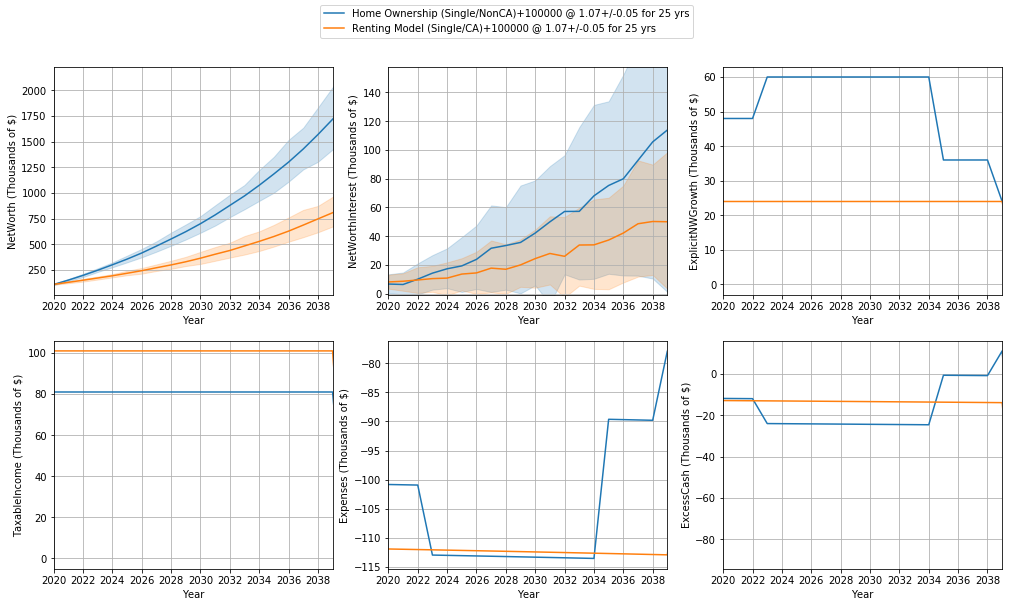

In [9]:
fm = glf.FinancialModel(year=2019)

sim_results = [] # We'll append all sim results to this list for one large fm plot at the end
ho_single = glf.CashflowModel('Home Ownership (Single/NonCA)') #Home Ownership Model (as compared to renting, etc)
cm = ho_single
cm.add_yearly(100000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-2000, 'Pri. Res.', monthly_nw=2000, year_end=15)
cm.add_monthly(-1000, 'Sec. Res.', monthly_nw=1000, year_start=4, year_end=19)
cm.add_monthly(-400, 'Auto Costs', yearly_apr=1.01) # Two vehicles - car and truck, one as a 'beater'
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=25, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=25)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')


renting_single = glf.CashflowModel('Renting Model (Single/CA)', state_tax=glf.ca_tax_rates)
cm = renting_single
cm.add_yearly(120000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-2500, 'Primary Residence', monthly_nw=0)
cm.add_monthly(-400, 'Auto Costs', yearly_apr=1.01)
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3300, 'Monthly Spend') # CA is expensive
cm.add_yearly(-13500, 'Yearly Spend') # CA is expensive

sims_to_run = [ho_single, renting_single]
sim_results = []

for sim in sims_to_run:
    sim_results.append(fm.sim(sim, nyears=25, initial_nw=100000, nw_apr_avg=1.07, nw_apr_stdev=0.05))
# The default suffix is just standard deviation. The :0.80 suffix gives me the 10th and 90th percentile bars on plots
fm.plot(sim_results, suffix=':0.80')



In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def run_sims(nyears=25, initial_nw=600000, nw_apr_avg=1.06):
    sim_results = []
    for sim in sims_to_run:
        sim_results.append(fm.sim(sim, nyears=nyears, initial_nw=initial_nw, nw_apr_avg=nw_apr_avg, nw_apr_stdev=0.05))
    # The default suffix is just standard deviation. The :0.80 suffix gives me the 10th and 90th percentile bars on plots
    fm.plot(sim_results, suffix=':0.80')


In [6]:
interact_manual(run_sims, 
                nyears=widgets.IntSlider(min=5, max=50, step=5, value=25), 
                initial_nw=widgets.IntSlider(min=0, max=1000*1000, step=50*1000, value=600*1000), 
                nw_apr_avg=widgets.FloatSlider(min=0.9, max=1.2, step=0.02, value=1.06))

interactive(children=(IntSlider(value=25, description='nyears', max=50, min=5, step=5), IntSlider(value=600000…

<function __main__.run_sims(nyears=25, initial_nw=600000, nw_apr_avg=1.06)>

In [26]:
fm = glf.FinancialModel(year=2019)

sim_results = [] # We'll append all sim results to this list for one large fm plot at the end

# Comparing a few models today. Those that...
# Stay in CA for three years, renting the entire time, THEN movin to an MCOL area, renting for a year, then buying a home
# Move to a MCOL area in January, taking a pay cut, renting for a year, and then buying a home
# Second salary in the MCOL area to determine salary impact

ca_three = glf.CashflowModel('CA for Three Years', state_tax=glf.ca_tax_rates)
cm = ca_three
cm.add_yearly(210 * 1000, 'CA Salary', year_end=3, taxable=True)
cm.add_yearly(80 * 1000, 'CA Equity', year_end=3, taxable=True)
cm.add_yearly(200 * 1000, 'MCOL Salary', year_start=4, year_end=20, taxable=True)
cm.add_monthly(-4000, 'CA Rent', year_end=3)
cm.add_monthly(-2750, 'MCOL Rent', year_start=4, year_end=4)
cm.add_monthly(-3500, 'MCOL Mortgage', year_start=5, year_end=20, monthly_nw=1750)
cm.add_monthly(-400, 'Auto Costs')
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')

mcol_a = glf.CashflowModel('MCOL Immediately High')
cm = mcol_a
cm.add_yearly(200 * 1000, 'MCOL Salary', year_end=20, taxable=True)
cm.add_monthly(-2750, 'MCOL Rent', year_start=0, year_end=1)
cm.add_monthly(-3500, 'MCOL Mortgage', year_start=2, year_end=17, monthly_nw=1750)
cm.add_monthly(-400, 'Auto Costs')
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')

mcol_b = glf.CashflowModel('MCOL Immediately Low')
cm = mcol_b
cm.add_yearly(170 * 1000, 'MCOL Salary', year_end=20, taxable=True)
cm.add_monthly(-2750, 'MCOL Rent', year_start=0, year_end=1)
# inflation reduces the effective cost of a mortgage
cm.add_monthly(-3500, 'MCOL Mortgage', year_start=2, year_end=17, monthly_nw=1750)
cm.add_monthly(-400, 'Auto Costs')
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')

mcol_brf = glf.CashflowModel('MCOL Immediately Low Rent Forever')
cm = mcol_brf
cm.add_yearly(170 * 1000, 'MCOL Salary', year_end=20, taxable=True)
cm.add_monthly(-2750, 'MCOL Rent')
cm.add_monthly(-400, 'Auto Costs')
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')


sims_to_run = [ca_three, mcol_a, mcol_b, mcol_brf]
sim_results = []

for sim in sims_to_run:
    sim_results.append(fm.sim(sim, nyears=25, initial_nw=650 * 1000, nw_apr_avg=1.07, nw_apr_stdev=0.08))
# The default suffix is just standard deviation. The :0.80 suffix gives me the 10th and 90th percentile bars on plots



Starting sim for CA for Three Years+650000 @ 1.07+/-0.08 for 25 yrs ... Finished in 1.6 seconds
Starting sim for MCOL Immediately High+650000 @ 1.07+/-0.08 for 25 yrs ... Finished in 1.5 seconds
Starting sim for MCOL Immediately Low+650000 @ 1.07+/-0.08 for 25 yrs ... Finished in 1.6 seconds
Starting sim for MCOL Immediately Low Rent Forever+650000 @ 1.07+/-0.08 for 25 yrs ... Finished in 1.5 seconds


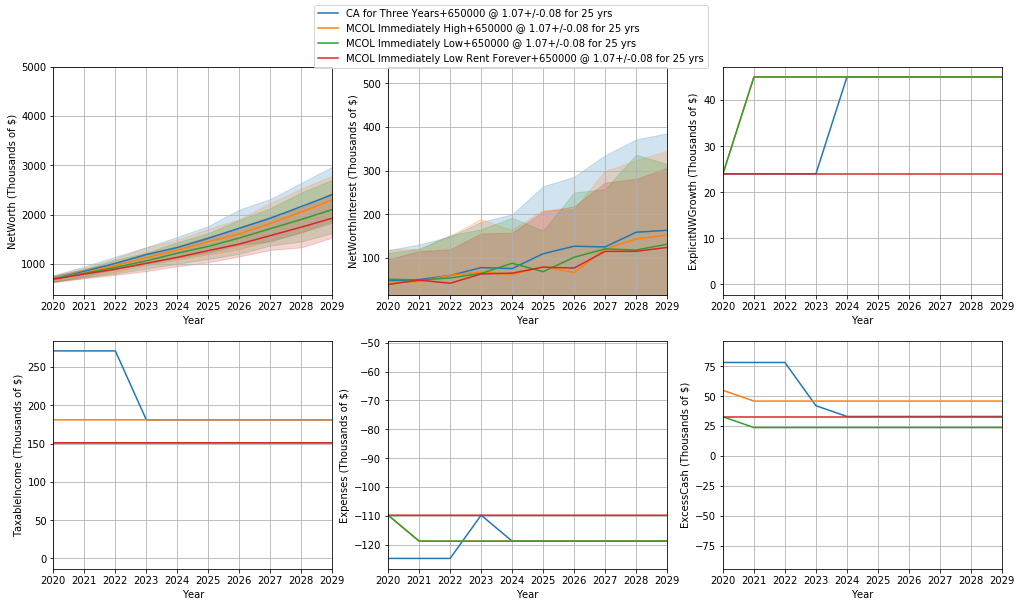

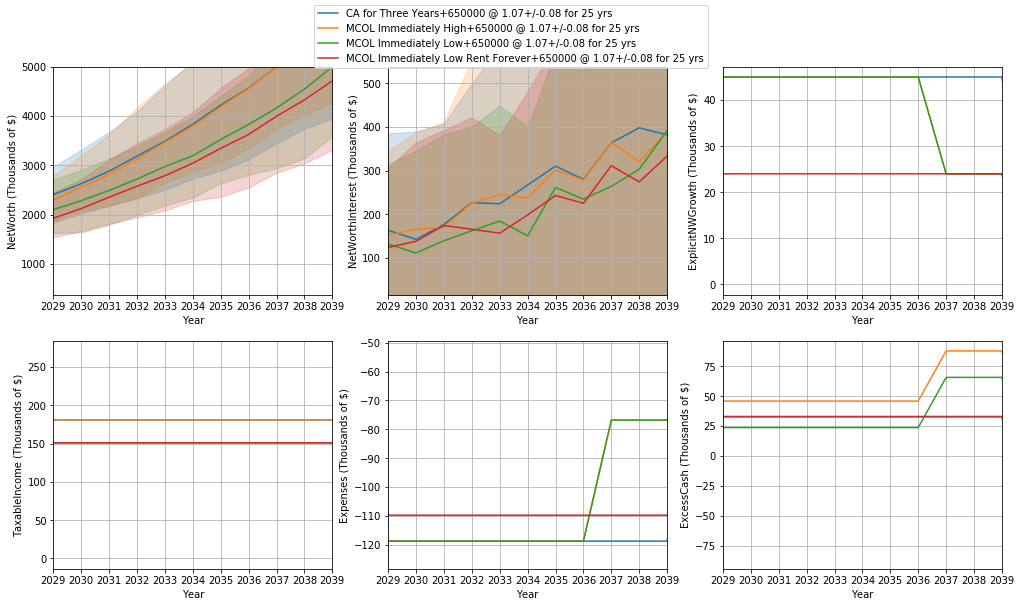

In [27]:
fm.plot(sim_results, suffix=':0.80', year_end=10)
fm.plot(sim_results, suffix=':0.80', year_start=10, year_end=20)

So. I am suspicous of how I handle mortgage an NW gain. I feel like I actually need to represent the property and the mortgage separately in terms of total net worth. Some sort of 'asset' type, that either has positive or negative net worth over time...

